In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [3]:
train_data_raw=pd.read_csv('./data/mnist_train.csv').astype('float32')
test_data_raw=pd.read_csv('./data/mnist_test.csv').astype('float32')

In [4]:
train_label=train_data_raw['label'].values
train_img=train_data_raw.drop('label', axis=1)

In [5]:
null_bool=train_img.isnull().to_numpy()
a=np.ones((784,1))
nullz=np.sum(np.dot(null_bool,a))
if nullz:
    print('there is missing data')
else:
    print('no missing data')

no missing data


In [6]:
train_img=train_img.values/255

test_img=test_data_raw.values/255

all_img=np.concatenate((train_img, test_img), axis=0)

train_img=train_img.reshape(-1,1,28,28)
test_img=test_img.reshape(-1,1,28,28)
all_img=all_img.reshape(-1,1,28,28)
print(all_img.shape)    


(70000, 1, 28, 28)


In [7]:
train_img.shape

(42000, 1, 28, 28)

In [8]:
# train_img, val_img, train_label, val_label = train_test_split(train_img, train_label, test_size=0.05, random_state=42)

In [9]:
train_img, train_label=T.from_numpy(train_img), T.from_numpy(train_label).type(T.LongTensor)
# val_img, val_label=T.from_numpy(val_img), T.from_numpy(val_label).type(T.LongTensor)
test_img=T.from_numpy(test_img)

# print(val_img.size(), val_label.size(), train_img.shape, train_label.shape)

<Figure size 432x216 with 0 Axes>

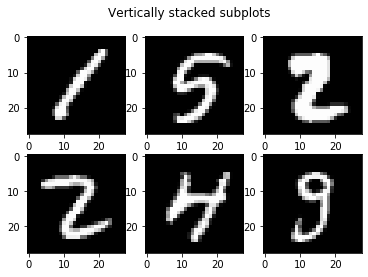

In [10]:
fig = plt.figure(figsize=(6,3))
fig, axs = plt.subplots(2,3)
fig.suptitle('Vertically stacked subplots')
for i in range(2):
    for j in range(3):
        axs[i,j].imshow(train_img[(i*3+j)*8,:][0], cmap='gray')
plt.show()

class DopeNet(nn.Module):
    
    def __init__(self):
        super(DopeNet, self).__init__()
        
        self.fc1= nn.Linear(784, 128)
        self.dropout= nn.Dropout(0.2)
        self.fc2= nn.Linear(128,96)
        self.fc3= nn.Linear(96, 10)
        
    
    def forward(self, input_x):
        x = F.relu(self.fc1(input_x))
        x = F.relu(self.dropout(self.fc2(x)))
        x = F.relu(self.fc3(x))
        
        return x
    
model=DopeNet().to('cuda')
print(model)

In [11]:
class DopeNet(nn.Module):
    
    def __init__(self):
        super(DopeNet, self).__init__()
        
        self.conv1= nn.Conv2d(1, 16, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2= nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1= nn.Linear(32*7*7,128)
        self.fc2= nn.Linear(128,64)
        self.fc3= nn.Linear(64, 10)
        
    
    def forward(self, input_x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(input_x))),2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))),2)
        x = x.view(-1,32*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model=DopeNet().to('cuda')
print(model)

DopeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [12]:
###HYPERPARAMETER
n_epoch=30
batch_size=64

train = T.utils.data.TensorDataset(train_img, train_label)
# val = T.utils.data.TensorDataset(val_img, val_label)


In [13]:
#create dataloader
train_loader= T.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
# val_loader= T.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)


In [14]:
###HYPERPARAMETER
lr=0.01
betas=(0.9,0.999)
momentum=0.9
decay_rate=0.95

criterion=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model.parameters(), lr=lr, betas=betas)
optimizer=optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# lr_sched = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
#train loop
count=0
loss_list=[]
val_list=[]
iteration=[]

for i in range(n_epoch):
    model.train()
    for j, (img, label) in enumerate(train_loader):
        img = img.to('cuda')
        label = label.to('cuda')
        optimizer.zero_grad()
        output=model(img)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        count+=1    
        
        if count%50 == 0:
#             correct=0
#             total=0
#             model.eval()
#             for images, labels in val_loader:
#                 with T.no_grad():
#                     images=images.to('cuda')
#                     labels=labels.to('cuda')
#                     outputs=model(images)
#                     val_loss=criterion(outputs,labels)
#                     pred=T.max(outputs.data, 1)[1]
#                     total+=len(labels)
# #                 print(len(images), len(labels), len(pred))
#                     correct += (pred == labels).sum()
#             accuracy = 100.0 * float(correct) / float(total)
            loss_list.append(loss.item())
#             val_list.append(val_loss.item())
            iteration.append(count)
    lr_sched.step()
            

    print('Epoch {} - Training Loss: {} | Val Loss: |  Val Accuracy:'.format(i, loss.item()))
    

Epoch 0 - Training Loss: 0.014476537704467773 | Val Loss: |  Val Accuracy:
Epoch 1 - Training Loss: 0.0020470619201660156 | Val Loss: |  Val Accuracy:
Epoch 2 - Training Loss: 0.001841425895690918 | Val Loss: |  Val Accuracy:
Epoch 3 - Training Loss: 0.00214385986328125 | Val Loss: |  Val Accuracy:
Epoch 4 - Training Loss: 0.0012684464454650879 | Val Loss: |  Val Accuracy:
Epoch 5 - Training Loss: 0.0008640289306640625 | Val Loss: |  Val Accuracy:
Epoch 6 - Training Loss: 0.00044858455657958984 | Val Loss: |  Val Accuracy:
Epoch 7 - Training Loss: 0.00033676624298095703 | Val Loss: |  Val Accuracy:
Epoch 8 - Training Loss: 7.474422454833984e-05 | Val Loss: |  Val Accuracy:
Epoch 9 - Training Loss: 1.049041748046875e-05 | Val Loss: |  Val Accuracy:
Epoch 10 - Training Loss: 2.0682811737060547e-05 | Val Loss: |  Val Accuracy:
Epoch 11 - Training Loss: 2.300739288330078e-05 | Val Loss: |  Val Accuracy:
Epoch 12 - Training Loss: 2.288818359375e-05 | Val Loss: |  Val Accuracy:
Epoch 13 - Tr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Predicted Digit = 2


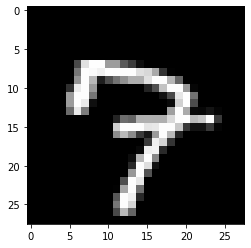

In [16]:
data=test_img[5][0]
plt.imshow(data, cmap='gray')
test_data=T.tensor(data).view(-1,1,28,28)

with T.no_grad():
    test_data=test_img.to('cuda')
    logps = model(test_data)

    
ps = T.exp(logps)
ps=ps.cpu()
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

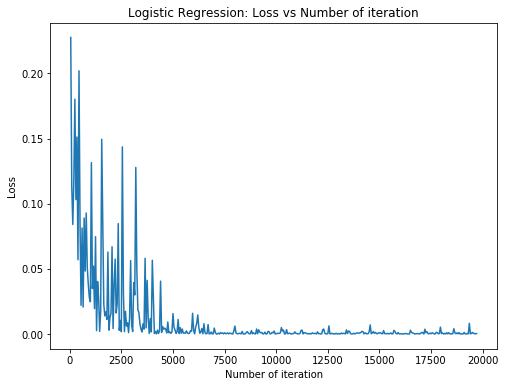

In [17]:
plt.figure(figsize=(8,6))
plt.plot(iteration,loss_list)
# plt.plot(iteration,val_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

In [18]:
T.save(model.state_dict(), 'mnist_inf_mj.pt')

In [19]:
T.save(model, 'mnist_mj_mod.pt')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DopeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
test = T.utils.data.TensorDataset(test_img)
print(test_img.shape)
test_loader= T.utils.data.DataLoader(test, batch_size=1, shuffle=False)

torch.Size([28000, 1, 28, 28])


In [21]:
predicts=[]
model.eval()
for [images] in test_loader:
    with T.no_grad():
        images=images.to('cuda')
        outputs=model(images)
        pred=T.max(outputs.data, 1)[1]
        predicts.append(pred.item())
        

In [22]:
print(len(predicts))


28000


In [23]:
id = range(1,28001)
print(id[3])

4


In [24]:
df = pd.DataFrame(list(zip(id,predicts)), columns=['ImageId', 'Label'])

In [25]:
df.to_csv('mj_mnist_cnn_3.csv')